In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras import layers

from keras.metrics import Accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

2025-01-15 08:06:38.619532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 08:06:39.201113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data if training is already done

In [3]:
data = np.load('../Results/lat.npz')
trainLat = data['xTrain']
testLat = data['xTest']

data = np.load('../Results/lon.npz')
trainLon = data['xTrain']
testLon = data['xTest']

data = np.load('../Results/trainScaled_pca.npz')
scaledXtrain_pca = data['xTrain']
yTrain = data['yTrain']

data = np.load('../Results/testScaled_pca.npz')
scaledXtest_pca = data['xTest']
yTest = data['yTest']

data = np.load('../Results/test.npz')
xTest = data['xTest']

### Pre-processing for training

In [4]:
f = "../Results/ML_Data_1HR.pkl"
data = pd.read_pickle(f)
data.head(3)

,fahrenheit,zscore,ndvi,lstLat,lstLon,stationID,tz,obsTimeUtc,obsTimeLocal,epoch,...,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal
46460,61.156944,-1.895117,0.333525,39.343576,-76.710610,LGC,America/New_York,2023-08-31 14:59:00+00:00,2023-08-31 10:59:00,1693493940,...,20.5,21.0,21.1,20.5,20.8,1013.72,1012.80,0.52,0.0,0.0
118497,73.995790,1.305722,0.266438,39.307951,-76.592487,ARK,America/New_York,2023-08-31 14:59:00+00:00,2023-08-31 10:59:00,1693493940,...,22.0,22.6,22.7,21.6,22.1,1008.81,1007.89,0.62,0.0,0.0
163026,85.743195,1.034689,0.012722,39.243907,-76.530551,ARK,America/New_York,2023-08-23 14:59:00+00:00,2023-08-23 10:59:00,1692802740,...,24.8,25.6,26.9,24.5,25.4,1015.92,1015.31,-0.32,0.0,0.0


### Drop time, quality control, and location based columns

In [5]:
data['qcStatus'].value_counts()

qcStatus
1    669309
Name: count, dtype: int64

In [6]:
y = data['fahrenheit']

x = data.drop( columns=['fahrenheit','zscore','epoch','tz',
                        'stationID', 'obsTimeUtc', 'obsTimeLocal', 'qcStatus',
                        'bsecLat', 'bsecLon','precipRate','precipTotal'] )
x.shape

(669309, 31)

### Convert temperature to Celcius to match BSEC data

In [7]:
y = (y - 32.) * (5/9)

In [8]:
x.columns

Index(['ndvi', 'lstLat', 'lstLon', 'bsecDistance', 'solarRadiationHigh',
       'uvHigh', 'winddirAvg', 'humidityHigh', 'humidityLow', 'humidityAvg',
       'tempHigh', 'tempLow', 'tempAvg', 'windspeedHigh', 'windspeedLow',
       'windspeedAvg', 'windgustHigh', 'windgustLow', 'windgustAvg',
       'dewptHigh', 'dewptLow', 'dewptAvg', 'windchillHigh', 'windchillLow',
       'windchillAvg', 'heatindexHigh', 'heatindexLow', 'heatindexAvg',
       'pressureMax', 'pressureMin', 'pressureTrend'],
      dtype='object')

### Bayesian Neural Network

In [9]:
# Methods to calculate aleatoric and epistemic uncertainty based on 
# formulas from study by Valdenegro-Toro and Mori

# Aleatoric uncertainty is defined as the mean of variances
def getAleatoric( variances ):

    aleatoric = []
    n = len( variances[0] ) # total number predictions made
    nEnsemble = len( variances ) # number of ensemble members

    for i in range(n):
        var = []
        for j in range(nEnsemble):
            var.append(variances[j][i])
        aleatoric.append( np.mean(var) )

    return aleatoric

# Epistemic uncertainty is defined as the variance of means
def getEpistemic( means ):

    epistemic = []
    n = len( means[0] ) # total number predictions made
    nEnsemble = len( means ) # number of ensemble members

    for i in range(n):
        mns = []
        for j in range(nEnsemble):
            mns.append(means[j][i])
        m = np.mean( mns )
        mns = np.array(mns)
        diffs = mns**2 - m**2
        epistemic.append( np.mean(diffs) )

    return epistemic

In [10]:
# Custom Loss Function 
import tensorflow as tf
import tensorflow_probability as tfp

def beta_nll_loss(beta=0.5):
    """
    Creates a Beta-NLL loss function for use with TensorFlow Probability 
    distribution outputs like tfp.layers.IndependentNormal.
    
    Args:
        beta (float): Parameter controlling the strength of the variance penalty.
                     beta = 1.0 recovers standard NLL
                     beta < 1.0 reduces penalty for large variances
    
    Returns:
        function: Loss function compatible with TFP distribution outputs
    """
    def loss(y_true, dist):
        # Get mean and variance from the distribution
        mean = dist.mean()
        var = dist.variance()
        
        # Compute squared error term
        sq_error = tf.square(y_true - mean)
        
        # Modified NLL with beta parameter
        loss = 0.5 * (tf.math.log(2 * np.pi) + beta * tf.math.log(var) + sq_error/var)
        
        return tf.reduce_mean(loss)
    
    return loss

In [11]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1
# The prior distribution is not trainable, as we fix its parameters
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

# Define variational posterior weight distribution as multivariate Gaussian
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [21]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [22]:
inputs = tf.keras.Input( scaledXtrain_pca.shape[1] )

# first hidden layer
hidden1 = tfp.layers.DenseVariational(units=14,
                                      make_prior_fn=prior,
                                      make_posterior_fn=posterior,
                                      kl_weight=1/len(scaledXtrain_pca),
                                      activation='sigmoid')(inputs)

# second hidden layer
hidden2 = tfp.layers.DenseVariational(units=7,
                                      make_prior_fn=prior,
                                      make_posterior_fn=posterior,
                                      kl_weight=1/len(scaledXtrain_pca),
                                      activation='sigmoid')(hidden1)

# Define output layer with 2 parameters (mean and variance)
distribution_params = Dense(units=2)(hidden2)
outputs = tfp.layers.IndependentNormal(1)(distribution_params)

bnn = keras.Model(inputs=inputs, outputs=outputs)

bnn.compile(loss=beta_nll_loss(beta=0.75), optimizer=keras.optimizers.RMSprop(learning_rate=0.01))

In [23]:
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational (DenseVar  (None, 14)               6440      
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 7)                5670      
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 2)                 16        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                             

In [24]:
history = bnn.fit( scaledXtrain_pca, yTrain, epochs=200, verbose=1, 
                     validation_split=0.2, batch_size=256 )

Epoch 1/200
1674/1674 [==============================] - 14s 8ms/step - loss: 6.1829 - val_loss: 2.2858
Epoch 2/200
1674/1674 [==============================] - 12s 7ms/step - loss: 2.2202 - val_loss: 2.1867
Epoch 3/200
1674/1674 [==============================] - 12s 7ms/step - loss: 2.1211 - val_loss: 2.0726
Epoch 4/200
1674/1674 [==============================] - 12s 7ms/step - loss: 2.0191 - val_loss: 1.9697
Epoch 5/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.9416 - val_loss: 1.9250
Epoch 6/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.9075 - val_loss: 1.8964
Epoch 7/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8861 - val_loss: 1.8767
Epoch 8/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8718 - val_loss: 1.8657
Epoch 9/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8627 - val_loss: 1.8579
Epoch 10/200
1674/1674 [==============================] - 12s 7m

1674/1674 [==============================] - 12s 7ms/step - loss: 1.8174 - val_loss: 1.8170
Epoch 80/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8168 - val_loss: 1.8147
Epoch 81/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8169 - val_loss: 1.8172
Epoch 82/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8165 - val_loss: 1.8152
Epoch 83/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8160 - val_loss: 1.8167
Epoch 84/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8160 - val_loss: 1.8182
Epoch 85/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8152 - val_loss: 1.8155
Epoch 86/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8151 - val_loss: 1.8183
Epoch 87/200
1674/1674 [==============================] - 12s 7ms/step - loss: 1.8145 - val_loss: 1.8151
Epoch 88/200
1674/1674 [==============================] - 12s 7ms/st

In [25]:
# serialize weights to HDF5
bnn.save_weights("./bnn_beta_nll.h5")

In [ ]:
bnn.load_weights("./bnn_beta_nll.h5")

(1.5, 4.0)

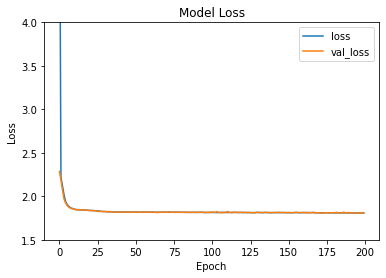

In [26]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(1.5,4)

#### Compute Uncertainties

In [27]:
# Obtain 100 distributions for each test value
means = np.zeros( shape=(100,scaledXtest_pca.shape[0]) )
variances = np.zeros( shape=(100,scaledXtest_pca.shape[0]) )

for i in range(100):

    predictions = bnn(scaledXtest_pca)
    means[i,:] = np.array( predictions.mean()[:,0] )
    variances[i,:] = np.array( predictions.variance()[:,0] )

means.shape, variances.shape

((100, 133862), (100, 133862))

In [28]:
# Aleatoric Uncertainty
aleatoric = getAleatoric(variances)

#Epsitemic Uncertainty
epistemic = getEpistemic(means)

len(aleatoric), len(epistemic)

(133862, 133862)

In [29]:
aggregatedVar = np.array(aleatoric) + np.array(epistemic)
aggregatedVar.shape

(133862,)

#### Aggregated Predictions

In [30]:
aggregatedMean = np.mean( means, axis=0 )
aggregatedMean.shape

(133862,)

In [31]:
# Determine widths of 95% credible interval
import arviz as az

counter  = 0

count = 0
widths = []

n = len(yTest)

for i in range(n):
    
    samples = np.random.normal( loc=aggregatedMean[i], 
                               scale=np.sqrt(aggregatedVar[i]), size=1000)

    hdi = az.hdi(samples,hdi_prob=0.95)
    if( (yTest[i] >= hdi[0]) and (yTest[i] <= hdi[1])): count += 1
    widths.append(hdi[1]-hdi[0])
    
    if ( counter < 3 ): 
        print( hdi, testLat[i], testLon[i], 
               np.round(aggregatedMean[i],2), np.round(aggregatedVar[i],2), np.round(yTest[i],2), 
               np.round(epistemic[i],2), np.round(aleatoric[i],2) )
        counter += 1

count/n

[ 9.34211007 31.45090117] 39.24696470167119 -76.62413176325326 20.29 5.68 21.12 0.52 5.17
[20.36185757 35.80803558] 39.32871474694949 -76.57625155122828 27.56 4.21 25.9 0.44 3.76
[20.31915254 32.62342455] 39.36506692951514 -76.58647064102884 26.19 3.33 27.32 0.25 3.09


0.9997235959420896

### MAE

In [32]:
mean_absolute_error(yTest, aggregatedMean)

1.261040461359089

In [33]:
def cTof (c):
    return (c * 9/5) + 32

(40.0, 100.0)

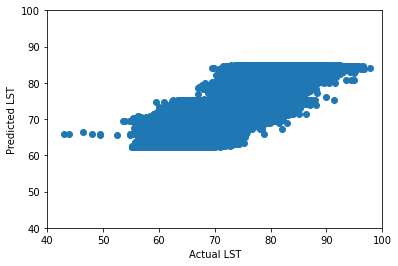

In [34]:
plt.scatter( cTof(yTest), cTof(aggregatedMean) )
plt.ylabel('Predicted LST')
plt.xlabel('Actual LST')
plt.xlim(40,100)
plt.ylim(40,100)

In [35]:
np.max(xTest[:,1]) # which column has a max of 12.9, which is the max BSEC distance?

12.96575991408698

(-15.0, 15.0)

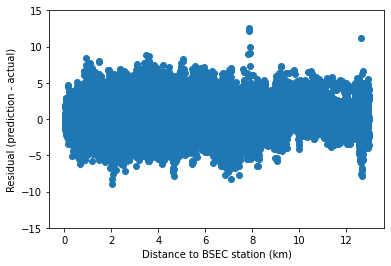

In [36]:
r = aggregatedMean - yTest
plt.scatter( xTest[:,1], r )
plt.xlabel('Distance to BSEC station (km)')
plt.ylabel('Residual (prediction - actual)')
plt.ylim(-15,15)

(-15.0, 15.0)

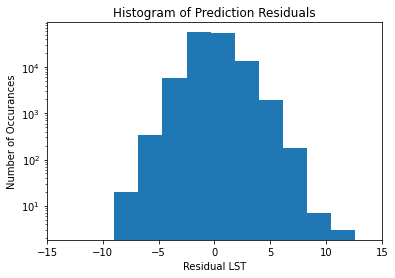

In [37]:
plt.hist(r)
plt.xlabel('Residual LST')
plt.ylabel('Number of Occurances')
plt.title('Histogram of Prediction Residuals')
plt.yscale('log')
plt.xlim(-15,15)

Text(0, 0.5, 'Latitude')

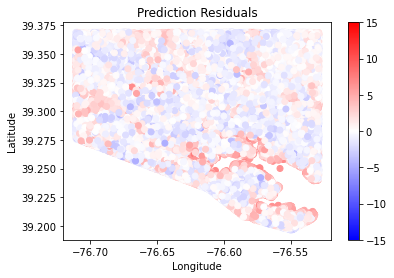

In [38]:
plt.scatter( testLon, testLat, c=r )
plt.set_cmap("bwr") # set colors to be blue to red
plt.colorbar()
plt.clim(-15,15)
plt.title('Prediction Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#### Example predictions

Text(0, 0.5, 'Latitude')

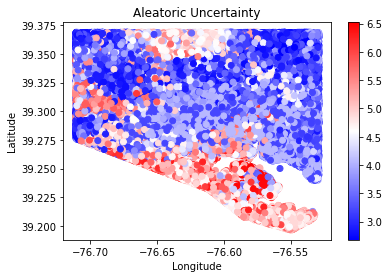

In [39]:
plt.scatter( testLon, testLat, c=aleatoric )
plt.colorbar()
plt.title('Aleatoric Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

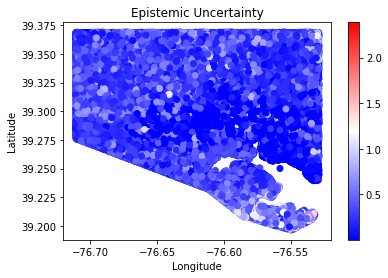

In [40]:
plt.scatter( testLon, testLat, c=epistemic )
plt.colorbar()
plt.title('Epistemic Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

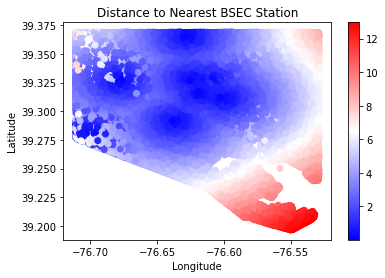

In [41]:
plt.scatter( testLon, testLat, c=xTest[:,1] )
plt.colorbar()
plt.title('Distance to Nearest BSEC Station')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

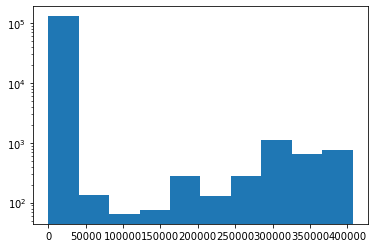

In [42]:
plt.hist( np.array(aleatoric)/np.array(epistemic) )
plt.yscale('log')

In [ ]:
np.min(epistemic), np.max(epistemic)

In [ ]:
# epistemic uncertainty thresholding

maes = []
percent = []

yTest = np.array(yTest)
mn, mx = np.min(epistemic), np.max(epistemic)
epiRange = np.linspace(mn, mx, 10)

for epi in epiRange:

    ix = np.where(epistemic <= epi)
    count = len(ix[0])
    subsetY = yTest[ix]
    subsetP = aggregatedMean[ix]
    mae = mean_absolute_error(subsetY, subsetP)
    mae = np.round(mae, 4)
    print("Epistemic Threshold:", np.round(epi,4), "MAE:", mae, ", % of Predictions Made:", count/len(y))
    maes.append(mae)
    percent.append(count/len(y))

In [ ]:
# Visual display of epistemic uncertainty thresholding
plt.plot(percent, maes,'-o')
plt.title("Proportion of Predictions vs MAE")
plt.xlabel("Proportion of Predictions Made")
plt.ylabel("MAE")
#plt.ylim(0.01,0.03)
#plt.colorbar()

In [ ]:
hdi

In [ ]:
# Visualize widths of credible intervals
plt.hist(widths)
plt.title("Credible Intervals Widths for Test Set")
plt.ylabel('Number of Occurances')
plt.xlabel('Width (Degrees)')

In [ ]:
plt.scatter( testLon, testLat, c=widths )
plt.colorbar()
plt.title('Credible Interval Widths')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Out of Distribution Examples

In [ ]:
subset = scaledXtest_pca[0:100,:]
subset = subset*5

In [ ]:
# Obtain 100 distributions for each test value
meansOOD = np.zeros( shape=(100,subset.shape[0]) )
variancesOOD = np.zeros( shape=(100,subset.shape[0]) )

for i in range(100):

    predictionsOOD = bnn(subset)
    meansOOD[i,:] = np.array( predictionsOOD.mean()[:,0] )
    variancesOOD[i,:] = np.array( predictionsOOD.variance()[:,0] )

meansOOD.shape, variancesOOD.shape

In [ ]:
# Aleatoric Uncertainty
aleatoricOOD = getAleatoric(variancesOOD)

#Epsitemic Uncertainty
epistemicOOD = getEpistemic(meansOOD)

len(aleatoricOOD), len(epistemicOOD)

In [ ]:
plt.hist(epistemic)
plt.hist(epistemicOOD, color='red')
plt.yscale('log')

In [ ]:
plt.hist(aleatoric)
plt.hist(aleatoricOOD, color='red')
plt.yscale('log')

In [ ]:
scaledXtest_pca[0,:]

In [ ]:
subset[0,:]